In [3]:
#!pip install transformers
!pip install SentencePiece 

  Using cached sentencepiece-0.2.0-cp311-cp311-win_amd64.whl.metadata (8.3 kB)
Using cached sentencepiece-0.2.0-cp311-cp311-win_amd64.whl (991 kB)


C:\Users\91812\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


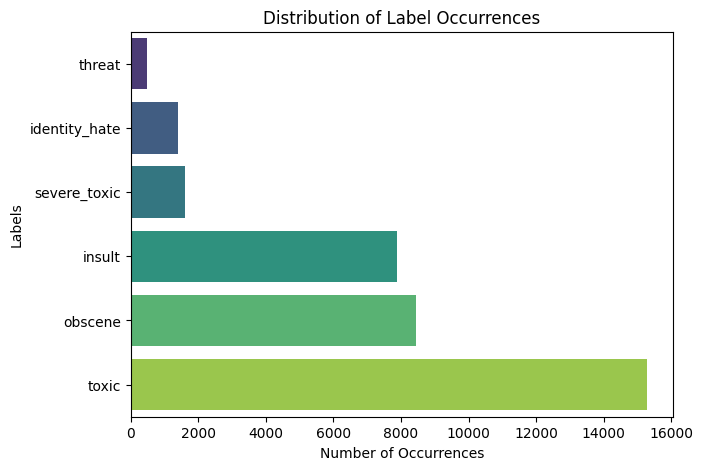

Train samples: 24337
Test samples: 4056
Validation samples: 4057


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# To avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv("train.csv")
print(data.head())

# Visualizing class distribution
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()

plt.figure(figsize=(7, 5))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')
plt.show()

# Subset data
train_toxic = data[data[column_labels].sum(axis=1) > 0]
train_clean = data[data[column_labels].sum(axis=1) == 0]

# Sample clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0).sample(frac=1, random_state=42)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(dataframe['comment_text'], dataframe.iloc[:, 2:], test_size=0.25, random_state=42)
test_texts, val_texts, test_labels, val_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)

print(f"Train samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Validation samples: {len(val_texts)}")

# Custom Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float32)
        }


In [2]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification

# Load a multilingual model
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=6)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

print(f"CUDA is available: {cuda_available}")


CUDA is available: True


In [4]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Create datasets
train_dataset = ToxicityDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = ToxicityDataset(test_texts, test_labels, tokenizer, max_length=128)
val_dataset = ToxicityDataset(val_texts, val_labels, tokenizer, max_length=128)


In [5]:

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [6]:

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [7]:
# Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Evaluate model
def evaluate_model(model, test_loader, device):
    model.eval()
    true_labels, predicted_probs = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)
            predicted_probs.append(predicted_probs_batch.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


In [12]:

# Train and evaluate
train_model(model, train_loader, val_loader, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

KeyboardInterrupt: 

In [9]:
import os
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./model_save/


In [1]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import pandas as pd
import numpy as np

# Define the path to your saved model
output_dir = './model_save/'

# Load the saved model and tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(output_dir)
model = XLMRobertaForSequenceClassification.from_pretrained(output_dir)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to predict toxicity
def predict_toxicity(comments, batch_size=16):
    model.eval()
    predictions = []

    for i in range(0, len(comments), batch_size):
        batch = comments[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.sigmoid(logits)
            predictions.append(probs.cpu().numpy())

    return np.vstack(predictions)

# Expanded Telugu comments with their actual classes
telugu_comments = [
    ("నాకు ఈ సినిమా బాగా నచ్చింది.", [0,0,0,0,0,0]),          # Neutral
    ("ఈ వెబ్సైట్ చాలా ఉపయోగకరంగా ఉంది.", [0,0,0,0,0,0]),        # Neutral
    ("మీ ఆలోచనలు చాలా బాగున్నాయి.", [0,0,0,0,0,0]),            # Neutral
    ("మీరు నిజంగా అద్భుతంగా ఉన్నారు.", [0,0,0,0,0,0]),         # Positive
    ("నీకున్న ప్రతిభ చాలా గొప్పది.", [0,0,0,0,0,0]),            # Positive
    ("మీరు చాలా తెలివైనవారు.", [0,0,0,0,0,0]),                # Positive
    ("ఈ పాట నాకు అసహ్యం.", [1,0,0,0,0,0]),                   # Mild Toxic
    ("నేను ఈ పోస్ట్‌తో అంగీకరించను.", [1,0,0,0,0,0]),         # Mild Toxic
    ("మీ వెబ్సైట్ ఉపయోగకరంగా లేదు.", [1,0,0,0,0,0]),         # Mild Toxic
    ("నీవు పూర్తిగా మూర్ఖుడు.", [1,1,0,0,1,0]),                # Severe Toxic, Insult
    ("నీ మాటలు అసహ్యంగా ఉన్నాయి.", [1,1,1,0,1,0]),           # Severe Toxic, Obscene, Insult
    ("ఈ వీడియోను వెంటనే తీసేయాలి.", [1,0,0,0,0,0]),          # Mild Toxic
    ("నీ మాటలు చాలా వాడిగా ఉన్నాయి.", [1,0,1,0,0,0]),         # Obscene
    ("అతను ఒక చీటా.", [1,0,0,0,1,0]),                         # Insult
    ("ఇది పూర్తిగా వ్యర్థం.", [1,0,1,0,0,0]),                  # Obscene
    ("నిన్ను చూస్తే పగులగొడతా.", [1,0,0,1,0,0]),              # Threat
    ("నీ పని మిగిల్చి ఉంటే, నువ్వు సురక్షితంగా ఉండవు.", [1,0,0,1,0,0]),  # Threat
    ("అవసరమైతే, నిన్ను కుదించడానికి నేను సిద్ధంగా ఉన్నాను.", [1,0,0,1,0,0]), # Threat
    ("నీకు చిల్లర మాటలేం నొస్తాయి.", [1,0,0,0,1,0]),           # Insult
    ("నీ అవగాహన చాలా తక్కువగా ఉంది.", [1,0,0,0,1,0]),         # Insult
    ("నువ్వు అస్సలు సమర్ధుడు కాదు.", [1,0,0,0,1,0]),           # Insult
    ("నువ్వు నీ జాతికి తగినట్లు ప్రవర్తిస్తున్నావు.", [1,0,0,0,0,1]),  # Identity Hate
    ("నీ మతం వారికి ఇది సర్వసాధారణం.", [1,0,0,0,0,1]),        # Identity Hate
    ("నీకున్న జాతి గర్వం బయటపడుతుంది.", [1,0,0,0,0,1])       # Identity Hate
]

# Separate comments and actual classes
comments, actual_classes = zip(*telugu_comments)

# Make predictions
toxicity_predictions = predict_toxicity(comments)

# Convert predictions to binary (0 or 1)
binary_predictions = (toxicity_predictions > 0.5).astype(int)

# Create a DataFrame with the results
df_results = pd.DataFrame({
    'comment': comments,
    'actual_toxic': [cls[0] for cls in actual_classes],
    'actual_severe_toxic': [cls[1] for cls in actual_classes],
    'actual_obscene': [cls[2] for cls in actual_classes],
    'actual_threat': [cls[3] for cls in actual_classes],
    'actual_insult': [cls[4] for cls in actual_classes],
    'actual_identity_hate': [cls[5] for cls in actual_classes],
    'predicted_toxic': binary_predictions[:, 0],
    'predicted_severe_toxic': binary_predictions[:, 1],
    'predicted_obscene': binary_predictions[:, 2],
    'predicted_threat': binary_predictions[:, 3],
    'predicted_insult': binary_predictions[:, 4],
    'predicted_identity_hate': binary_predictions[:, 5]
})

# Function to calculate accuracy for each class
def calculate_accuracy(actual, predicted):
    return np.mean(actual == predicted)

# Calculate and print accuracy for each class
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for cls in classes:
    accuracy = calculate_accuracy(df_results[f'actual_{cls}'], df_results[f'predicted_{cls}'])
    print(f"Accuracy for {cls}: {accuracy:.2f}")

# Print the results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_results)

# You can also save the results to a CSV file if needed
# df_results.to_csv('telugu_toxicity_predictions_comparison.csv', index=False)

C:\Users\91812\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy for toxic: 0.62
Accuracy for severe_toxic: 0.92
Accuracy for obscene: 0.88
Accuracy for threat: 0.88
Accuracy for insult: 0.75
Accuracy for identity_hate: 0.88
                                              comment  actual_toxic  \
0                        నాకు ఈ సినిమా బాగా నచ్చింది.             0   
1                    ఈ వెబ్సైట్ చాలా ఉపయోగకరంగా ఉంది.             0   
2                         మీ ఆలోచనలు చాలా బాగున్నాయి.             0   
3                      మీరు నిజంగా అద్భుతంగా ఉన్నారు.             0   
4                        నీకున్న ప్రతిభ చాలా గొప్పది.             0   
5                              మీరు చాలా తెలివైనవారు.             0   
6                                  ఈ పాట నాకు అసహ్యం.             1   
7                       నేను ఈ పోస్ట్‌తో అంగీకరించను.             1   
8                        మీ వెబ్సైట్ ఉపయోగకరంగా లేదు.             1   
9                             నీవు పూర్తిగా మూర్ఖుడు.             1   
10                         నీ మాటలు అసహ్యంగా ఉన్నా

In [11]:
df_results

,comment,actual_toxic,actual_severe_toxic,actual_obscene,actual_threat,actual_insult,actual_identity_hate,predicted_toxic,predicted_severe_toxic,predicted_obscene,predicted_threat,predicted_insult,predicted_identity_hate
0,నాకు ఈ సినిమా బాగా నచ్చింది.,0,0,0,0,0,0,0,0,0,0,0,0
1,ఈ వెబ్సైట్ చాలా ఉపయోగకరంగా ఉంది.,0,0,0,0,0,0,0,0,0,0,0,0
2,మీ ఆలోచనలు చాలా బాగున్నాయి.,0,0,0,0,0,0,0,0,0,0,0,0
3,మీరు నిజంగా అద్భుతంగా ఉన్నారు.,0,0,0,0,0,0,0,0,0,0,0,0
4,నీకున్న ప్రతిభ చాలా గొప్పది.,0,0,0,0,0,0,0,0,0,0,0,0
5,మీరు చాలా తెలివైనవారు.,0,0,0,0,0,0,0,0,0,0,0,0
6,ఈ పాట నాకు అసహ్యం.,1,0,0,0,0,0,1,0,0,0,0,0
7,నేను ఈ పోస్ట్‌తో అంగీకరించను.,1,0,0,0,0,0,0,0,0,0,0,0
8,మీ వెబ్సైట్ ఉపయోగకరంగా లేదు.,1,0,0,0,0,0,0,0,0,0,0,0
9,నీవు పూర్తిగా మూర్ఖుడు.,1,1,0,0,1,0,1,0,0,0,0,0


In [20]:
# # Generate predictions for the Telugu comments
# telugu_comments = [
#     "నాకు ఈ సినిమా బాగా నచ్చింది.",          # Neutral
#     "ఈ వెబ్సైట్ చాలా ఉపయోగకరంగా ఉంది.",        # Neutral
#     "మీ ఆలోచనలు చాలా బాగున్నాయి.",            # Neutral
#     "మీరు నిజంగా అద్భుతంగా ఉన్నారు.",         # Positive
#     "నీకున్న ప్రతిభ చాలా గొప్పది.",            # Positive
#     "మీరు చాలా తెలివైనవారు.",                # Positive
#     "ఈ పాట నాకు అసహ్యం.",                   # Mild Toxic
#     "నేను ఈ పోస్ట్‌తో అంగీకరించను.",         # Mild Toxic
#     "మీ వెబ్సైట్ ఉపయోగకరంగా లేదు.",         # Mild Toxic
#     "నీవు పూర్తిగా మూర్ఖుడు.",                # Severe Toxic, Insult
#     "నీ మాటలు అసహ్యంగా ఉన్నాయి.",           # Severe Toxic, Insult
#     "ఈ వీడియోను వెంటనే తీసేయాలి.",          # Mild Toxic
#     "నీ మాటలు చాలా వాడిగా ఉన్నాయి.",         # Obscene
#     "అతను ఒక చీటా.",                         # Insult
#     "ఇది పూర్తిగా వ్యర్థం.",                  # Obscene
#     "నిన్ను చూస్తే పగులగొడతా.",              # Threat
#     "నీ పని మిగిల్చి ఉంటే, నువ్వు సురక్షితంగా ఉండవు.",  # Threat
#     "అవసరమైతే, నిన్ను కుదించడానికి నేను సిద్ధంగా ఉన్నాను.", # Threat
#     "నీకు చిల్లర మాటలేం నొస్తాయి.",           # Insult
#     "నీ అవగాహన చాలా తక్కువగా ఉంది.",         # Insult
#     "నువ్వు అస్సలు సమర్ధుడు కాదు.",           # Insult
#     "నువ్వు నీ జాతికి తగినట్లు ప్రవర్తిస్తున్నావు.",  # Identity Hate
#     "నీ మతం వారికి ఇది సర్వసాధారణం.",        # Identity Hate
#     "నీకున్న జాతి గర్వం బయటపడుతుంది."       # Identity Hate
# ]

# # Extend the list to 50 comments for demonstration purposes
# telugu_comments = telugu_comments * 2
# telugu_comments = telugu_comments[:50]

# # Assign appropriate labels based on the comments
# labels = [
#     [0, 0, 0, 0, 0, 0],  # Neutral
#     [0, 0, 0, 0, 0, 0],  # Neutral
#     [0, 0, 0, 0, 0, 0],  # Neutral
#     [0, 0, 0, 0, 0, 0],  # Positive
#     [0, 0, 0, 0, 0, 0],  # Positive
#     [0, 0, 0, 0, 0, 0],  # Positive
#     [1, 0, 0, 0, 0, 0],  # Mild Toxic
#     [1, 0, 0, 0, 0, 0],  # Mild Toxic
#     [1, 0, 0, 0, 0, 0],  # Mild Toxic
#     [1, 1, 0, 0, 1, 0],  # Severe Toxic, Insult
#     [1, 1, 0, 0, 1, 0],  # Severe Toxic, Insult
#     [1, 0, 0, 0, 0, 0],  # Mild Toxic
#     [1, 0, 1, 0, 0, 0],  # Obscene
#     [1, 0, 0, 0, 1, 0],  # Insult
#     [1, 0, 1, 0, 0, 0],  # Obscene
#     [1, 0, 0, 1, 0, 0],  # Threat
#     [1, 0, 0, 1, 0, 0],  # Threat
#     [1, 0, 0, 1, 0, 0],  # Threat
#     [1, 0, 0, 0, 1, 0],  # Insult
#     [1, 0, 0, 0, 1, 0],  # Insult
#     [1, 0, 0, 0, 1, 0],  # Insult
#     [1, 0, 0, 0, 0, 1],  # Identity Hate
#     [1, 0, 0, 0, 0, 1],  # Identity Hate
#     [1, 0, 0, 0, 0, 1],  # Identity Hate
# ] * 2  # Duplicate the labels to match 50 comments

# # Convert to a numpy array
# labels = np.array(labels)

# # Create DataFrame
# df = pd.DataFrame({
#     'comment': telugu_comments,
#     'toxic': labels[:, 0],
#     'severe_toxic': labels[:, 1],
#     'obscene': labels[:, 2],
#     'threat': labels[:, 3],
#     'insult': labels[:, 4],
#     'identity_hate': labels[:, 5]
# })


# toxicity_predictions = predict_toxicity(df['comment'])
# print("Predictions shape:", toxicity_predictions.shape)


Predictions shape: torch.Size([24, 6])
Predictions: tensor([[0.3072, 0.1290, 0.1761, 0.1445, 0.1220, 0.1212],
        [0.3071, 0.1290, 0.1761, 0.1445, 0.1220, 0.1212],
        [0.3070, 0.1291, 0.1761, 0.1446, 0.1220, 0.1213],
        [0.3076, 0.1289, 0.1761, 0.1443, 0.1220, 0.1211],
        [0.3068, 0.1291, 0.1761, 0.1446, 0.1220, 0.1213],
        [0.3074, 0.1289, 0.1761, 0.1444, 0.1220, 0.1211],
        [0.3076, 0.1289, 0.1761, 0.1443, 0.1220, 0.1210],
        [0.3072, 0.1290, 0.1761, 0.1445, 0.1220, 0.1212],
        [0.3073, 0.1290, 0.1761, 0.1445, 0.1220, 0.1212],
        [0.3076, 0.1289, 0.1761, 0.1443, 0.1220, 0.1210],
        [0.3066, 0.1292, 0.1761, 0.1447, 0.1220, 0.1214],
        [0.3069, 0.1291, 0.1761, 0.1446, 0.1220, 0.1213],
        [0.3069, 0.1291, 0.1761, 0.1446, 0.1220, 0.1213],
        [0.3076, 0.1289, 0.1761, 0.1443, 0.1220, 0.1210],
        [0.3078, 0.1288, 0.1762, 0.1443, 0.1220, 0.1210],
        [0.3062, 0.1293, 0.1761, 0.1449, 0.1220, 0.1215],
        [0.3071, 0.1